## Задача исследования

**Задача** — предсказать медианную стоимость дома в жилом массиве (`median_house_value`) на основе данных о жилье в Калифорнии в 1990 году.  

Для оценки качества модели используются **метрики**:  
- RMSE  
- MAE  
- R²  

---

**Описание признаков датасета:**

- `longitude` — долгота  
- `latitude` — широта  
- `housing_median_age` — медианный возраст жителей жилого массива  
- `total_rooms` — общее количество комнат в домах жилого массива  
- `total_bedrooms` — общее количество спален в домах жилого массива  
- `population` — количество человек, которые проживают в жилом массиве  
- `households` — количество домовладений в жилом массиве  
- `median_income` — медианный доход жителей жилого массива  
- `median_house_value` — медианная стоимость дома в жилом массиве *(целевой признак)*  
- `ocean_proximity` — близость к океану  

## Этапы исследования и выводы

1. **Загрузка данных и библиотек.**  
   Проведена инициализация окружения, импортированы необходимые библиотеки для анализа и построения модели.  

2. **Подготовка данных.**  
   - Данные разделены на обучающую и тестовую выборки.  
   - В признаке `total_bedrooms` были пропуски. Для их заполнения использован географический принцип: жилые массивы сгруппированы по широте и долготе, и в пределах каждой группы пропуски заменены на медианные значения.  
   - Решение основано на предположении, что соседние жилые массивы обладают схожими характеристиками.  

3. **Формирование признаков.**  
   - В предобработке применены стандартные методы: `OneHotEncoder` для категориального признака `ocean_proximity` и `StandardScaler` для числовых признаков.  
   - Пайплайн построен максимально простым, без кастомных классов.  

4. **Обучение модели.**  
   - Реализован единый пайплайн для обучения и оценки качества.  
   - Проведено обучение на разных наборах признаков (все признаки / только числовые).  
   - Добавление категориального признака дало прирост метрик качества на **5–10%**, что подтверждает его ценность.  

**Вывод (по шагу 2):** данные успешно подготовлены, модель обучена, подтверждено, что категориальный признак `ocean_proximity` вносит значимый вклад в предсказания и его необходимо сохранять в итоговом датасете.  

## Загрузка библиотек и данных, инициализация сессии

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as plt
import pyspark
import pyspark.sql.functions as F

from pyspark.sql import SparkSession, Row, Column
from pyspark.sql.types import *
from pyspark.ml.feature import (
    Bucketizer,
    StringIndexer,
    OneHotEncoder,
    VectorAssembler, 
    StandardScaler
)

from pyspark.sql.window import Window

from pyspark.ml import Pipeline, PipelineModel

from pyspark.ml.regression import LinearRegression

from pyspark.ml.evaluation import RegressionEvaluator

# Настройка размеров графиков по умолчанию
plt.rcParams['figure.figsize'] = (10,5)

In [2]:
spark = SparkSession.builder \
                    .master("local") \
                    .appName("ML_project_in_spark") \
                    .getOrCreate()

In [3]:
df = spark.read.load('/datasets/housing.csv', format="csv", sep=",", inferSchema=True, header="true")
df.printSchema()
df.show(5)

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR B

In [4]:
df.describe().toPandas()

,summary,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,count,20640,20640,20640,20640,20433,20640,20640,20640,20640,20640
1,mean,-119.56970445736148,35.6318614341087,28.639486434108527,2635.7630813953488,537.8705525375618,1425.4767441860465,499.5396802325581,3.8706710029070246,206855.81690891474,None
2,stddev,2.003531723502584,2.135952397457101,12.58555761211163,2181.6152515827944,421.38507007403115,1132.46212176534,382.3297528316098,1.899821717945263,115395.61587441359,None
3,min,-124.35,32.54,1.0,2.0,1.0,3.0,1.0,0.4999,14999.0,<1H OCEAN
4,max,-114.31,41.95,52.0,39320.0,6445.0,35682.0,6082.0,15.0001,500001.0,NEAR OCEAN


## Подготовка данных

**Разбиение данных на тренировочную и тестовую выборки**

In [5]:
# разделение данных на тренировочную и тестовую выборки
train, test = df.randomSplit([0.8, 0.2], seed=42)
print(train.count(), test.count()) 

16560 4080


**Заполнение пропусков**

In [6]:
# пропущенные значения
columns = df.columns

for column in columns:
    check_col = F.isnan(column) | F.isnull(column)
    print(column, df.filter(check_col).count())

longitude 0
latitude 0
housing_median_age 0
total_rooms 0
total_bedrooms 207
population 0
households 0
median_income 0
median_house_value 0
ocean_proximity 0


Согласно данным каждая строка содержит агрегированную статистику о жилом массиве, а жилой массив — минимальная географическая единица с населением от 600 до 3000 человек в зависимости от штата. Предполоижим, что жилые массивы обладают схожими характеристиками со своими соседями. Исходя их этого пропуски в признаке total_bedrooms можно заполнить медианным значением группы соседствующих жилых массивов. Группы сформируем по георафическому принципу воспользовавшись широтой и долготой.
Соберем группы "топорным" методом - разобъем значения широты и долготы на группы в рамках каждого признака которые, конкатенацией, соберем в группы широта-долгота. Также не будем из функции с логикой заполнения пропусков создавать класс с целью включения его в пайплайн. Т.к. в задаче используем одну модель, пайплайн будет включать в себя только предобработку признаков стандартными методами OneHotEncoder и StandardScaler.

In [7]:
# диапозон географичеких координат
df.select(['longitude', 'latitude']).describe().show()

+-------+-------------------+-----------------+
|summary|          longitude|         latitude|
+-------+-------------------+-----------------+
|  count|              20640|            20640|
|   mean|-119.56970445736148| 35.6318614341087|
| stddev|  2.003531723502584|2.135952397457101|
|    min|            -124.35|            32.54|
|    max|            -114.31|            41.95|
+-------+-------------------+-----------------+



In [8]:
# функция заполнения пропусков в признаке total_bedrooms
def filling_total_beds(df):
    # разбиение географичеких координат на корзины
    to_bins = {
    'longitude': [-float('inf'), -124, -123, -122, -121, -120, -119, -118, -117, -116, -115, -114,  float('inf')],
    'latitude': [-float('inf'), 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, float('inf')]
    }

    for key, val in to_bins.items():
        bucketizer = Bucketizer(
            splits=val,
            inputCol=key,
            outputCol=f"{key}_bins"
        )
        df = bucketizer.transform(df)
        
        
    # координаты групп жилых массивов
    df = df.withColumn('geo_tag_bins', F.concat(F.col('longitude_bins'), F.col('latitude_bins')))
    
    # расчет медианных значений признака total_bedrooms в группах жилых массивов
    geo_bins_window = Window.partitionBy('geo_tag_bins')

    df = df.withColumn(
        'median_bedrooms',
        F.expr('percentile_approx(total_bedrooms, 0.5)').over(geo_bins_window) # expr - парсит строку (медианы в F не работает; percentile_approx считает приближенную медиану)
    )
    
    # признак total_bedrooms без пропусков
    df = df.withColumn(
        'total_bedrooms_filled',
        F.when(F.col('total_bedrooms').isNull() | F.isnan('total_bedrooms'), F.col('median_bedrooms'))
        .otherwise(F.col('total_bedrooms'))
    )
    
    return df

In [9]:
# заполнение пропусков в тренировочной и тестовой выборках
train_filled = filling_total_beds(train)
test_filled = filling_total_beds(test)

In [10]:
# проверка заполнения пропущенных значений
columns = train_filled.columns

print('Тренировочный датасет')
for column in columns:
    check_col = F.isnan(column) | F.isnull(column)
    print(column, train_filled.filter(check_col).count())

print('Тестовый датасет')
for column in columns:
    check_col = F.isnan(column) | F.isnull(column)
    print(column, test_filled.filter(check_col).count())

Тренировочный датасет
longitude 0
latitude 0
housing_median_age 0
total_rooms 0
total_bedrooms 157
population 0
households 0
median_income 0
median_house_value 0
ocean_proximity 0
longitude_bins 0
latitude_bins 0
geo_tag_bins 0


median_bedrooms 0


total_bedrooms_filled 0
Тестовый датасет
longitude 0
latitude 0
housing_median_age 0
total_rooms 0
total_bedrooms 50
population 0
households 0
median_income 0
median_house_value 0
ocean_proximity 0
longitude_bins 0
latitude_bins 0
geo_tag_bins 0


median_bedrooms 0


total_bedrooms_filled 0


**Датасеты без пропусков**

In [11]:
# сборка датасета без служебных признаков
tr_fin = train_filled.select([
    'longitude',
    'latitude',
    'housing_median_age',
    'total_rooms',
    'total_bedrooms_filled',
    'population',
    'households',
    'median_income',
    'median_house_value',
    'ocean_proximity',
    'geo_tag_bins'
])


te_fin = test_filled.select([
    'longitude',
    'latitude',
    'housing_median_age',
    'total_rooms',
    'total_bedrooms_filled',
    'population',
    'households',
    'median_income',
    'median_house_value',
    'ocean_proximity',
    'geo_tag_bins'
])

## Обучение модели

**Пайплайн обработки признаков (OneHotEncoder  StandardScaler)**

In [12]:
# разделение признаков на группы
target = 'median_house_value'
cat_cols = [col[0] for col in tr_fin.dtypes if col[1] == 'string']
num_cols = [col[0] for col in tr_fin.dtypes if col[1] in ['int', 'double'] and col[0] != 'median_house_value']

In [13]:
# кодирование категориальных признаков OneHotEncoder
indexers = [StringIndexer(inputCol=c, outputCol=c+'_idx',
                          handleInvalid='keep') for c in cat_cols
] # handleInvalid - обработка неизвестных значений (сохраняем в колонку numLabels)

encoders = [OneHotEncoder(inputCol=c+'_idx', outputCol=c+'_ohe') for c in cat_cols]

cat_pipeline = Pipeline(stages=indexers + encoders)

In [14]:
# масштабирование числовых признаков
assembler_num = VectorAssembler(inputCols=num_cols, outputCol='num_features')

scaler = StandardScaler(inputCol='num_features', outputCol='num_scaled')

num_pipeline = Pipeline(stages=[assembler_num, scaler])

In [15]:
# сборка преобразованных признаков в один
assembler_final = VectorAssembler(
    inputCols=[c+'_ohe' for c in cat_cols] + ['num_scaled'], 
    outputCol='features'
)

**функция тренировки, обучения модели и оценка метрик**

In [16]:
# пустой DataFrame для метрик
metrics_df = pd.DataFrame(columns=['Feature', 'RMSE', 'MAE', 'R²'])
predictions_dict = {}
models = {}

# Функция оценки модели
def evaluate_model(tr_fin, te_fin, feature, target):
    global metrics_df, predictions_dict, models  # глобальная переменная, чтобы обновлять таблицу

    # Определяем модель линейной регрессии
    lr = LinearRegression(
        featuresCol=feature,  # Всегда используем закодированные признаки
        regParam=1,
        elasticNetParam=0,
        labelCol=target
    )

    # Финальный пайплайн обработки данных
    final_pipeline = Pipeline(stages=[cat_pipeline, num_pipeline, assembler_final, lr])

    # Обучаем модель
    model = final_pipeline.fit(tr_fin)
    models[feature] = model
    
    # Делаем предсказания
    predictions = model.transform(te_fin)
    predictions_dict[feature] = predictions#.toPandas()
    
    # Оценка метрик
    evaluator = RegressionEvaluator(labelCol=target, predictionCol='prediction')

    rmse = evaluator.setMetricName("rmse").evaluate(predictions)
    mae = evaluator.setMetricName("mae").evaluate(predictions)
    r2 = evaluator.setMetricName("r2").evaluate(predictions)

    # Добавляем строку в DataFrame
    new_row = pd.DataFrame({"Feature": [feature], "RMSE": [rmse], "MAE": [mae], "R²": [r2]})
    metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

**Обучениие, прогноз и оценка метрик на всех/ числовых признаках**

In [17]:
evaluate_model(tr_fin, te_fin, 'num_scaled', target)
evaluate_model(tr_fin, te_fin, 'features', target)

print(metrics_df)

25/10/01 17:08:13 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
25/10/01 17:08:13 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
25/10/01 17:08:17 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
25/10/01 17:08:17 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


      Feature          RMSE           MAE        R²
0  num_scaled  71796.560226  51808.485650  0.627436
1    features  66221.646405  46681.485129  0.683048


Метрики говорят нам о том, что единственный категориальный признак несет полезную информацию в себе, дающую прирост метрик от 5% до 10%. Исключать его из прогнозного датасета нецелесообразно.

## Анализ результатов

In [18]:
# ощибки предсказаний
predictions_dict['features'] = predictions_dict['features'].withColumn(
    'diff_%',
    (F.col('median_house_value') - F.col('prediction')) / F.col('median_house_value')
)

predictions_dict['features'] = predictions_dict['features'].withColumn(
    'diff_abs',
    F.col('median_house_value') - F.col('prediction')
)

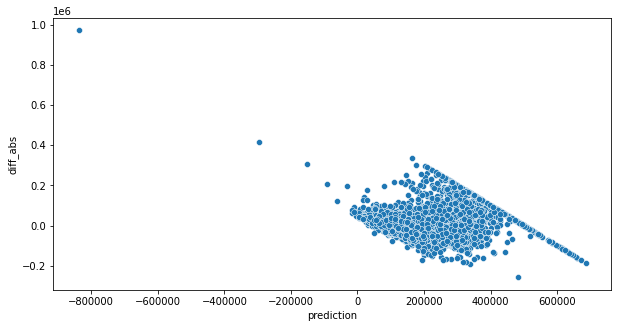

In [19]:
# диаграмма рассеинея остатков
df_pandas = predictions_dict['features'].toPandas()
sns.scatterplot(x=df_pandas['prediction'], y=df_pandas['diff_abs']);

# добавить title, подпись осей, сетку - поиск решения

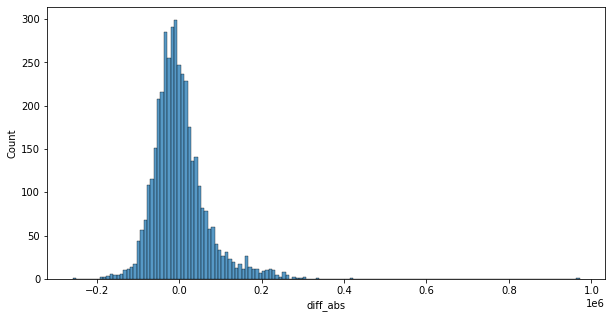

In [20]:
# гистограмма остатков
sns.histplot(df_pandas['diff_abs']);

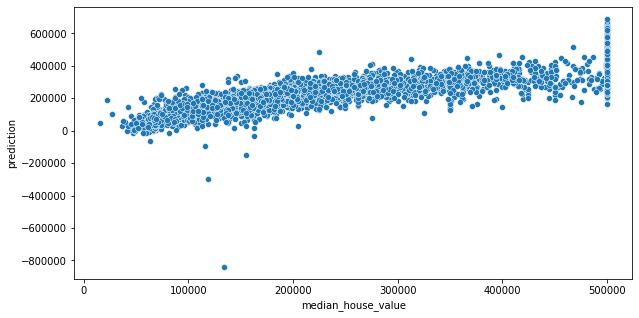

In [21]:
# диаграмма фактические значения против предсказаний
sns.scatterplot(x=df_pandas['median_house_value'], y=df_pandas['prediction']);

In [22]:
# завершим сессию
spark.stop()

1. Диспресия остоков не равномерна на всем интервале, также наблюдается кластер значения которого расположились в линию (аномальные объекты стоимостью 490к+)
2. Длинный правый хвост на гистограмме остатков как и отрицательные предсказания говорят о наличии выбросов
3. Отрицательные значения предсказаний вероятно обусловлены наличием ряда очень дорогих объектов

В результате, можно заключить что модель не очень пригодня для использования. Причиной посредственного качества модели являются данные требующие очистки от выбросов и аномальных значений. 

## Выводы

1. Анализ остатков показал **неравномерную дисперсию** и наличие кластеров с аномально высокими значениями (особенно объекты с ценой **490k+**).  
2. Гистограмма остатков демонстрирует длинный правый хвост, а также отрицательные предсказания, что свидетельствует о выбросах в данных.  
3. Отрицательные прогнозные значения вероятно связаны с присутствием в датасете очень дорогих объектов, выбивающихся из общей структуры.  

**Итоговый вывод:** текущая модель в её виде непригодна для практического применения. Ключевая причина посредственного качества — наличие выбросов и аномальных значений в данных. Для улучшения прогноза требуется очистка выборки и более тщательная предобработка.  